# lorapy data processing

In [1]:
%load_ext autoreload
%autoreload 2

import pathlib

import os, sys
from loguru import logger
logger.remove(None)
logger.add(sys.stdout, colorize=True)

import numpy as np

import matplotlib.pyplot as plt 
plt.style.use('dark_background')
%matplotlib inline

In [2]:
# from lorapy.io.load import DatLoader
import lorapy

## setup 

In [3]:
DATA_DIR = pathlib.Path('/Users/trevor/Work/1-projects/lora-processing/data/lora-benchtop-recording')

## utils

In [4]:
import random
rand = lambda mx: random.randint(0, mx)

# load

In [5]:
loader = lorapy.load(DATA_DIR, autoload=True)
loader.filelist

2020-04-04 22:35:11.135 | DEBUG    | lorapy.io.load:_process_data_dir:68 - set datafile directory: /Users/trevor/Work/1-projects/lora-processing/data/lora-benchtop-recording
2020-04-04 22:35:11.139 | INFO     | lorapy.io.load:_process_data_dir:74 - found 110 datafile file(s)


[DatFile('lora_BW2_SF10_915MHz_20ksps_Att100_v0.dat'),
 DatFile('lora_BW2_SF12_915MHz_20ksps_Att80_v0.dat'),
 DatFile('lora_BW2_SF10_915MHz_20ksps_Att0_v0.dat'),
 DatFile('lora_BW2_SF10_915MHz_20ksps_Att40_v0.dat'),
 DatFile('lora_BW2_SF11_915MHz_20ksps_Att60_v0.dat'),
 DatFile('lora_BW2_SF11_915MHz_20ksps_Att120_v0.dat'),
 DatFile('lora_BW2_SF12_915MHz_20ksps_Att20_v0.dat'),
 DatFile('lora_BW2_SF11_915MHz_20ksps_Att40_v0.dat'),
 DatFile('lora_BW2_SF10_915MHz_20ksps_Att60_v0.dat'),
 DatFile('lora_BW2_SF12_915MHz_20ksps_Att0_v0.dat'),
 DatFile('lora_BW2_SF11_915MHz_20ksps_Att100_v0.dat'),
 DatFile('lora_BW2_SF10_915MHz_20ksps_Att120_v0.dat'),
 DatFile('lora_BW2_SF10_915MHz_20ksps_Att20_v0.dat'),
 DatFile('lora_BW2_SF12_915MHz_20ksps_Att60_v0.dat'),
 DatFile('lora_BW2_SF11_915MHz_20ksps_Att140_v0.dat'),
 DatFile('lora_BW2_SF12_915MHz_20ksps_Att100_v0.dat'),
 DatFile('lora_BW2_SF11_915MHz_20ksps_Att80_v0.dat'),
 DatFile('lora_BW2_SF10_915MHz_20ksps_Att80_v0.dat'),
 DatFile('lora_BW2_SF12_

In [6]:
for file in loader.filelist:
    break
    
file

DatFile('lora_BW2_SF10_915MHz_20ksps_Att100_v0.dat')

In [7]:
tar_filename = 'lora_BW9_SF11_915MHz_20ksps_Att20_v0.dat'

file = [file for file in loader.filelist if file.name == tar_filename][0]
file

DatFile('lora_BW9_SF11_915MHz_20ksps_Att20_v0.dat')

# process

## convert 

In [8]:
signal = file.to_signal()
signal

2020-04-04 22:35:11.263 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 800 and packet length: 24200
2020-04-04 22:35:11.329 | INFO     | lorapy.datafile.file:load:61 - loaded 15975424 samples from file


LoraSignal(length=15975424)

In [9]:
signal.stats

BW: 9 | SF: 11 | Att: 20 | samples per symbol: 800 | packet length: 24200

## extract packets

In [10]:
signal.extract_packets(method='slide-mean', auto_adj=True)

2020-04-04 22:35:11.405 | INFO     | lorapy.signals.signal:_process_signal:116 - selected "slide-mean" processing method
2020-04-04 22:35:11.456 | INFO     | lorapy.signals.processing.sliding_mean:_find_all_mindices:55 - scanning signal for padding locations..
2020-04-04 22:35:11.457 | DEBUG    | lorapy.signals.processing.sliding_mean:_find_all_mindices:59 - iteration 0
2020-04-04 22:35:11.486 | DEBUG    | lorapy.signals.processing.sliding_mean:_find_all_mindices:59 - iteration 50
2020-04-04 22:35:11.508 | DEBUG    | lorapy.signals.processing.sliding_mean:_find_all_mindices:59 - iteration 100
2020-04-04 22:35:11.536 | DEBUG    | lorapy.signals.processing.sliding_mean:_find_all_mindices:59 - iteration 150
2020-04-04 22:35:11.560 | DEBUG    | lorapy.signals.processing.sliding_mean:_find_all_mindices:59 - iteration 200
2020-04-04 22:35:11.586 | DEBUG    | lorapy.signals.processing.sliding_mean:_find_all_mindices:59 - iteration 250
2020-04-04 22:35:11.623 | DEBUG    | lorapy.signals.proces

/Users/trevor/miniconda3/envs/py37-prime/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


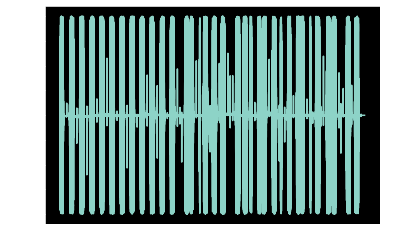

In [11]:
plt.plot(signal._raw_packets[rand(signal.num_packets), :])

## inspect packets

In [12]:
for packet in signal.packets:
    break
    
packet

LoraPacket(id=0) || size: 24200 | BW: 9 | SF: 11 | Att: 20 | samples per symbol: 800 | packet length: 24200

In [13]:
packet.endpoints

(12050, 36250)

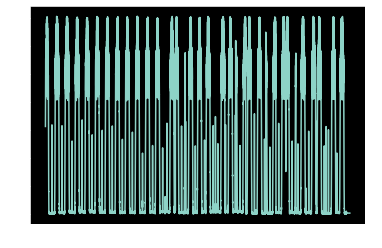

In [14]:
packet.plot()

In [15]:
packet.adjustment

0

### random packet

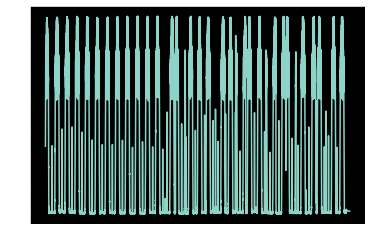

In [32]:
packet = signal.packets[rand(signal.num_packets)]
packet.plot()

In [45]:
start, stop = packet.endpoints
start, stop

(8546870, 8571070)

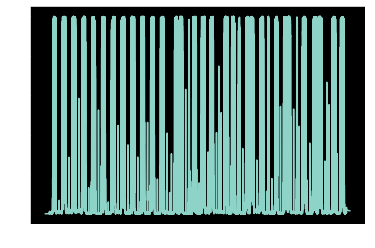

In [55]:
plt.plot(signal.real_abs_signal[start-600:stop])

## symbol test

In [33]:
numSymbols = 8
symbols = np.empty([signal.num_packets * numSymbols, int(signal.stats.samp_per_sym)], dtype='complex')
N = symbols.shape[0]

k,l = 0, 0

for i in range(signal.num_packets):
    for j in range(numSymbols):
        
        symbols[l,:] = signal._raw_packets[i, k:k+signal.stats.samp_per_sym]
        k = k + signal.stats.samp_per_sym
        l = l+1
    k = 0
    
print("Total Symbols: " + str(symbols.shape[0]))

Total Symbols: 5040


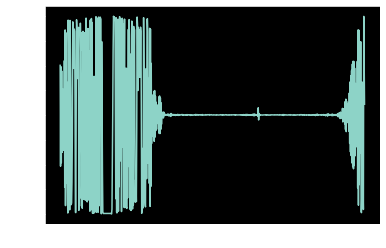

In [43]:
plt.plot(symbols[rand(symbols.shape[0]), :])